## Generate Anchors using K-mean clustering

Anchor is a pre-defined width/height for the network to make network predict easier. Instead of directly predicting the network, our network predicts coordinate values `tx, ty, tw, th` for each cell in its output feature map. By indirectly predicting the position of bounding box relative to cell coordinates and using anchors, the network improve its numerical stabability and converge faster. 

In order to convert to bounding box, we use location of the cell `(cx, cy)`, where the center of the ground truth locates inside, and anchor `(pw, ph)` to scale the prediction as the following formula (note that everything is in relative size):
````
Transform Prediction into bounding box:
bx = sigmoid(tx) + cx
by = sigmoid(ty) + cy
bw = pw * exp(tw)
bh = ph * exp(th)
````

**K-mean Clustering**: Instead of hand-picking the anchors, we take advantage of training data to generate anchors based on the ground truth bounding boxes. This allows the network to converge faster. In this work, we selected 5 number of anchors as it is a good trade off between speed and accuracy. Having more anchors allows us to predict more accurately, however, it would also slow down the prediction speed. By plotting the `W` and `H` ratio, we might see that the width and height ratio is linearly dependent to its size.



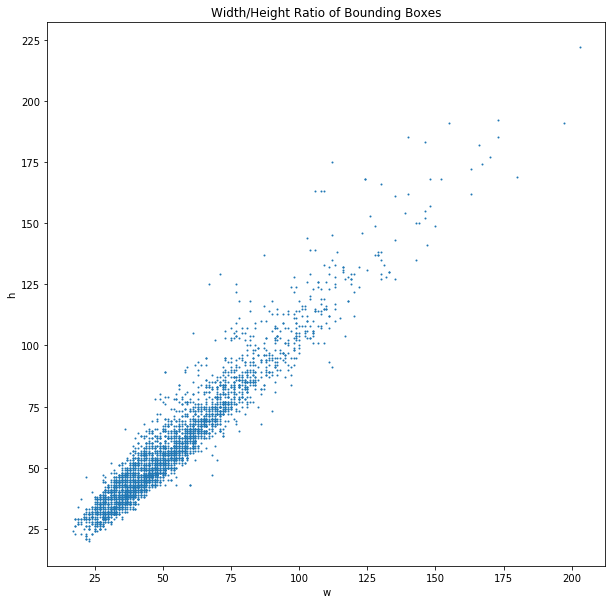

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

label_path   = '../data/training.txt'  # lisa extension training data using save_lisa_to_txt(path_to_lisa_training)
data = pd.read_csv(label_path, sep=",", header = None, names=['image','x1','y1','x2','y2','label'])
data['w'] = data['x2'] - data['x1']
data['h'] = data['y2'] - data['y1']
data[0:2]
# Visualize ratio between 'w' and 'y'
data.plot.scatter(x='w',y='h', figsize=(10,10), s=1, title='Width/Height Ratio of Bounding Boxes')

In [19]:
import numpy as np
def k_mean_cluster(n_anchors, gt_boxes, loss_convergence=1e-5):
    """
    Cluster anchors.
    """
    # initial random centroids
    centroid_indices = np.random.choice(len(gt_boxes), k)
    centroids = []
    for centroid_index in centroid_indices:
        centroids.append(gt_boxes[centroid_index])

    # iterate k-means
    anchors, avg_iou, loss = run_k_mean(n_anchors, gt_boxes, centroids)
    while True:
        anchors, avg_iou, curr_loss = run_k_mean(n_anchors, gt_boxes, anchors)
        if abs(loss - curr_loss) < loss_convergence:
            break
        loss = curr_loss

    return anchors, avg_iou


def run_k_mean(n_anchors, boxes, centroids):
    """
    Perform K-mean clustering on training ground truth to generate anchors. 
    In the paper, authors argues that generating anchors through anchors would improve Recall of the network

    NOTE: Euclidean distance produces larger errors for larger boxes. Therefore, YOLOv2 did not use Euclidean distance 
          to measure calculate loss. Instead, it uses the following formula:

                    d(box, centroid) = 1−IOU(box, centroid)

    :param n_anchors: K-value , number of desired anchors box
    :param boxes:      list of bounding box in format [x1, y1, w, h]
    :param centroids: 
    :return: 
        new_centroids: set of new anchors
        groups:        wth?
        loss:          compared to current bboxes
    """
    loss = 0
    groups = []
    new_centroids = []
    for i in range(n_anchors):
        groups.append([])
        new_centroids.append(Box(0, 0, 0, 0))

    for box in boxes:
        min_distance = 1
        group_index = 0

        for i, centroid in enumerate(centroids):
            distance = (1 - box_iou(box, centroid))
            if distance < min_distance:
                min_distance = distance
                group_index = i

        groups[group_index].append(box)
        loss += min_distance
        new_centroids[group_index].w += box.w
        new_centroids[group_index].h += box.h

    for i in range(n_anchors):
        if len(groups[i]) == 0:
            continue
        new_centroids[i].w /= len(groups[i])
        new_centroids[i].h /= len(groups[i])

    iou = 0
    counter = 0
    for i, anchor in enumerate(new_centroids):
        for gt_box in groups[i]:
            iou += box_iou(gt_box, anchor)
            counter += 1

    avg_iou = iou / counter
    # print("Average IOU: {:4f}".format(avg_iou))  
    return new_centroids, avg_iou, loss


def convert_bbox(x1, y1, x2, y2):
    w = float(x2) - float(x1)
    h = float(y2) - float(y1)
    xc = float(x1) + w / 2.
    yc = float(y1) + h / 2.
    return xc, yc, w, h


def scale_rel_box(img_size, box):
    """
    Scale bounding box relative to image size
    """
    width, height, _ = img_size
    dw = 1. / width
    dh = 1. / height
    xc = (box.x) * dw
    yc = (box.y) * dh
    w = (box.w) * dw
    h = (box.h) * dh
    return xc, yc, w, h


class Box(object):
    def __init__(self, xc, yc, w, h):
        self.x = xc
        self.y = yc
        self.w = w
        self.h = h


def box_iou(b1, b2):
    intersect = box_intersection(b1, b2)
    union = box_union(b1, b2)
    iou = float(intersect / union)
    return iou


def box_intersection(b1, b2):
    w = overlap(b1.x, b1.w, b2.x, b2.w)
    h = overlap(b1.x, b1.h, b2.x, b2.h)
    if (w < 0) or (h < 0): return 0
    area = w * h
    return area


def overlap(x1, w1, x2, w2):
    l1 = x1 - (w1 / 2.)
    l2 = x2 - (w2 / 2.)
    r1 = x1 + (w1 / 2.)
    r2 = x2 + (w2 / 2.)
    left = l1 if l1 >= l2 else l2
    right = r1 if r1 <= r2 else r2
    return right - left


def box_union(b1, b2):
    intersect = box_intersection(b1, b2)
    union = (b1.w * b1.h) + (b2.w * b2.h) - intersect
    return union



In [20]:
k            = 5  # num_anchors
loss_conv    = 1e-5
img_size     = [1280, 960, 0]
feature_map  = [d/32 for d in img_size]    # DarkNet19 on YOLOv2 Max-pool 5 times --> output'size shrinked 2^5 = 32 times
gt_boxes = []

with open(label_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        img_path, x1, y1, x2, y2, label = line.rstrip().split(",")
        xc, yc, w, h = convert_bbox(x1, y1, x2, y2)
        xc, yc, w, h = scale_rel_box(img_size, Box(xc, yc, w, h))
        gt_boxes.append(Box(0, 0, float(w), float(h))) # since we calculate w h of anchors, we do not take xc yc into account
print("Number of ground truth boxes: {} boxes".format(len(gt_boxes)))

Number of ground truth boxes: 3672 boxes


In [21]:
## K-MEAN CLUSTERING
anchor_list = []
avg_iou_list = []
for k in list(range(1, 12)):
    anchors, avg_iou = k_mean_cluster(k, gt_boxes, loss_convergence=1e-6)
    print("K = {:2} | AVG_IOU:{:-4f} ".format(k, avg_iou))
    anchor_list.append(anchors)
    avg_iou_list.append(avg_iou)

K =  1 | AVG_IOU:0.575513 
K =  2 | AVG_IOU:0.707510 
K =  3 | AVG_IOU:0.765600 
K =  4 | AVG_IOU:0.806577 
K =  5 | AVG_IOU:0.830067 
K =  6 | AVG_IOU:0.844719 
K =  7 | AVG_IOU:0.860660 
K =  8 | AVG_IOU:0.871698 
K =  9 | AVG_IOU:0.878639 
K = 10 | AVG_IOU:0.881103 
K = 11 | AVG_IOU:0.886696 


Anchor [K =5] on LISA Dataset:

(0.04450034340659346, 0.064308608058608)
(0.08816276658767774, 0.1294924960505529)
(0.023717899133663362, 0.035715759075907606)
(0.03283318210930825, 0.0483890193566751)
(0.059577141608391594, 0.08738709207459215)


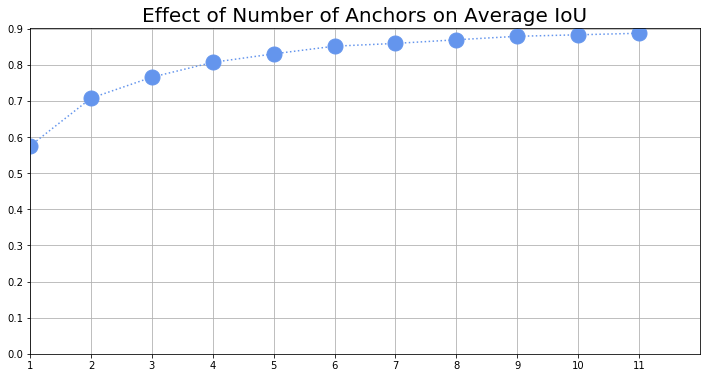

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
marker_style = dict(color='cornflowerblue', linestyle=':', marker='o',
                    markersize=15, markerfacecoloralt='gray')

x = list(range(1, 12))
plt.figure(figsize=(12, 6))
plt.plot(x, avg_iou_list, fillstyle='full', **marker_style)
plt.grid()
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(1, 12, 1.0))
plt.xlim([1, 12] ) # this line
plt.title("Effect of Number of Anchors on Average IoU", fontsize=20)
# print result
print("Anchor [K =5] on LISA Dataset:\n")
for anchor in anchor_list[4]:  # Select K = 5 
    print(anchor.w , anchor.h)

Anchors Absolute size:
[[  31.01211454   34.95154185]
 [  58.11086475   63.03325942]
 [  78.02803738   85.96635514]
 [  42.98154657   47.44200351]
 [ 115.21164021  126.58201058]]


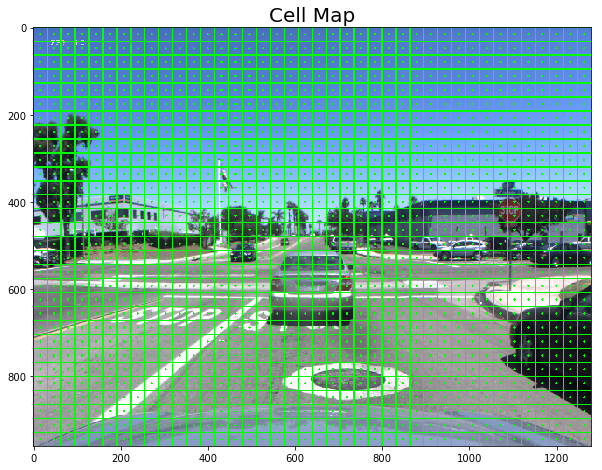

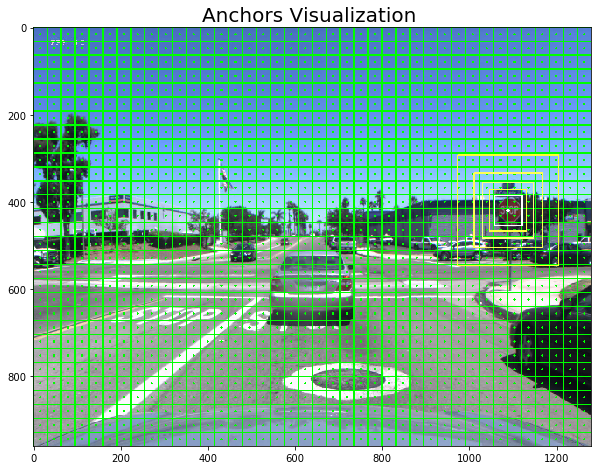

In [18]:
import cv2
sample_data ='../test_images/stop_1405106680.avi_image9.png'

anchors = np.array(((0.02422821448237885, 0.036407856093979445),
                    (0.045399113082039956, 0.0656596452328159),
                    (0.06095940420560741, 0.08954828660436143),
                    (0.0335793332601054, 0.04941875366139418),
                    (0.09000909391534395, 0.13185626102292766)))

img = cv2.cvtColor(cv2.imread(sample_data), cv2.COLOR_BGR2RGB)
height, width, c = img.shape

shrink_factor = 32
grid_w = list(range(width/shrink_factor))
grid_h = list(range(height/shrink_factor))
center = 0
# Plot grid map
for r in grid_w:
    img = cv2.line(img,(r*shrink_factor, 0), (r*shrink_factor, height), color=(0, 255, 0), thickness=2)
    
for h in grid_h:
    img = cv2.line(img,(0, h*shrink_factor), (width, h*shrink_factor), color=(0, 255, 0), thickness=2)
    
# Plot center point
for r in grid_w:
    for h in grid_h:
        centroid = ((r + 1)*shrink_factor - shrink_factor/2, (h+1)*shrink_factor - shrink_factor/2)
        img = cv2.circle(img, centroid, radius=1, color=(0, 255, 0), thickness=2)
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.title('Cell Map', fontsize=20)

print("Anchors Absolute size:")
print(anchors*np.array([width, height]))
center = (1090, 420)  # of stop sign - hand picked
sample = cv2.circle(img, center, radius=2, color=(255, 255, 255), thickness=4)

for i in range(len(anchors)):
    p1 = center + anchors[i]*np.array([width, height])
    p2 = center - anchors[i]*np.array([width, height])
    result = cv2.rectangle(sample,tuple(p1.astype(int)),tuple(p2.astype(int)),(255, 255, int(255/(i+1))), thickness=2)
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.title("Anchors Visualization ", fontsize=20)
result = img